# Bigram

- a `bigram` is essentially a two-word unit that helps us understand how words co-occur and potentially reveal relationships between them.

- Examples of Bigrams:
  - "I love"
  - "machine learning"

## Bigram Character Model

- In Natural Language Processing (NLP), a `bigram character model` focuses on analyzing sequences of `two consecutive characters`, instead of words, to understand and predict the next character in a sequence.
- i.e. given an initial character, predict the next character.

In [68]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,torch,lightning --conda

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
torch    : 2.2.2
lightning: 2.2.1

conda environment: torch_p11



In [69]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
## Load text data
fp: str = "../../../data/names.txt"

with open(fp, "r") as f:
    # Read all the lines as a list
    names: list[str] = f.read().splitlines()

names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [71]:
## Data summary
total: int = len(names)
min_name_len: int = min(len(name) for name in names)
max_name_len: int = max(len(name) for name in names)

console.print(
    (
        f"Total number of names: {total:,} "
        f"\nmin name length: {min_name_len} \nmax name length: {max_name_len}"
    )
)

Total number of names: 32,034 
min name length: 2 
max name length: 15

In [72]:
SPECIAL_TOKEN: str = "<S>"

# Read 2 words at a time
for w in names[:1]:
    # Add special character(s) between words
    word: list[str] = [SPECIAL_TOKEN] + list(w) + [SPECIAL_TOKEN]
    for ch1, ch2 in zip(word, word[1:]):
        print(f"{ch1:3} {ch2:3}")

<S> e  
e   m  
m   m  
m   a  
a   <S>


In [73]:
# Create a count of the bigram characters
SPECIAL_TOKEN: str = "<S>"
SMOOTHING: int = 1
bigram: dict[str, int] = {}

# Read 2 words at a time
for w in names:
    # Add special character(s) between words
    word: list[str] = [SPECIAL_TOKEN] + list(w) + [SPECIAL_TOKEN]
    for ch1, ch2 in zip(word, word[1:]):
        bigram[(ch1, ch2)] = bigram.get((ch1, ch2), SMOOTHING) + 1

# bigram

In [74]:
# Top 10 bigrams
sorted(bigram.items(), key=lambda x: x[1], reverse=True)[:10]

[(('n', '<S>'), 6764),
 (('a', '<S>'), 6641),
 (('a', 'n'), 5439),
 (('<S>', 'a'), 4411),
 (('e', '<S>'), 3984),
 (('a', 'r'), 3265),
 (('e', 'l'), 3249),
 (('r', 'i'), 3034),
 (('n', 'a'), 2978),
 (('<S>', 'k'), 2964)]

### Store the bigrams in an array/tensor


In [75]:
# Number of unique characters
characters: list[str] = sorted(set([x for name in names for x in name]))
characters.insert(0, SPECIAL_TOKEN)

print(f"Number of unique characters: {len(characters)}")
characters

Number of unique characters: 27


['<S>',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [76]:
import torch
from torch import Tensor


num_chars: int = len(characters)
# Use int since it'll be storing counts.
# torch.ones instead of zeros for model smoothening
bigram_tensor: Tensor = torch.ones(size=(num_chars, num_chars), dtype=torch.int32)

bigram_tensor[:5]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], dtype=torch.int32)

In [77]:
# Convert text to numbers.
text_to_num: dict[str, int] = {text: idx for idx, text in enumerate(characters)}

# Convert numbers to text
num_to_text: dict[int, str] = {idx: text for text, idx in text_to_num.items()}


console.print(text_to_num, num_to_text)

{
    '<S>': 0,
    'a': 1,
    'b': 2,
    'c': 3,
    'd': 4,
    'e': 5,
    'f': 6,
    'g': 7,
    'h': 8,
    'i': 9,
    'j': 10,
    'k': 11,
    'l': 12,
    'm': 13,
    'n': 14,
    'o': 15,
    'p': 16,
    'q': 17,
    'r': 18,
    's': 19,
    't': 20,
    'u': 21,
    'v': 22,
    'w': 23,
    'x': 24,
    'y': 25,
    'z': 26
}
{
    0: '<S>',
    1: 'a',
    2: 'b',
    3: 'c',
    4: 'd',
    5: 'e',
    6: 'f',
    7: 'g',
    8: 'h',
    9: 'i',
    10: 'j',
    11: 'k',
    12: 'l',
    13: 'm',
    14: 'n',
    15: 'o',
    16: 'p',
    17: 'q',
    18: 'r',
    19: 's',
    20: 't',
    21: 'u',
    22: 'v',
    23: 'w',
    24: 'x',
    25: 'y',
    26: 'z'
}

In [78]:
# Read 2 words at a time
for w in names:
    # Add special character(s) between words
    word: list[str] = [SPECIAL_TOKEN] + list(w) + [SPECIAL_TOKEN]
    for ch1, ch2 in zip(word, word[1:]):
        # Convert to index
        idx1, idx2 = text_to_num.get(ch1), text_to_num.get(ch2)
        bigram_tensor[idx1, idx2] += 1

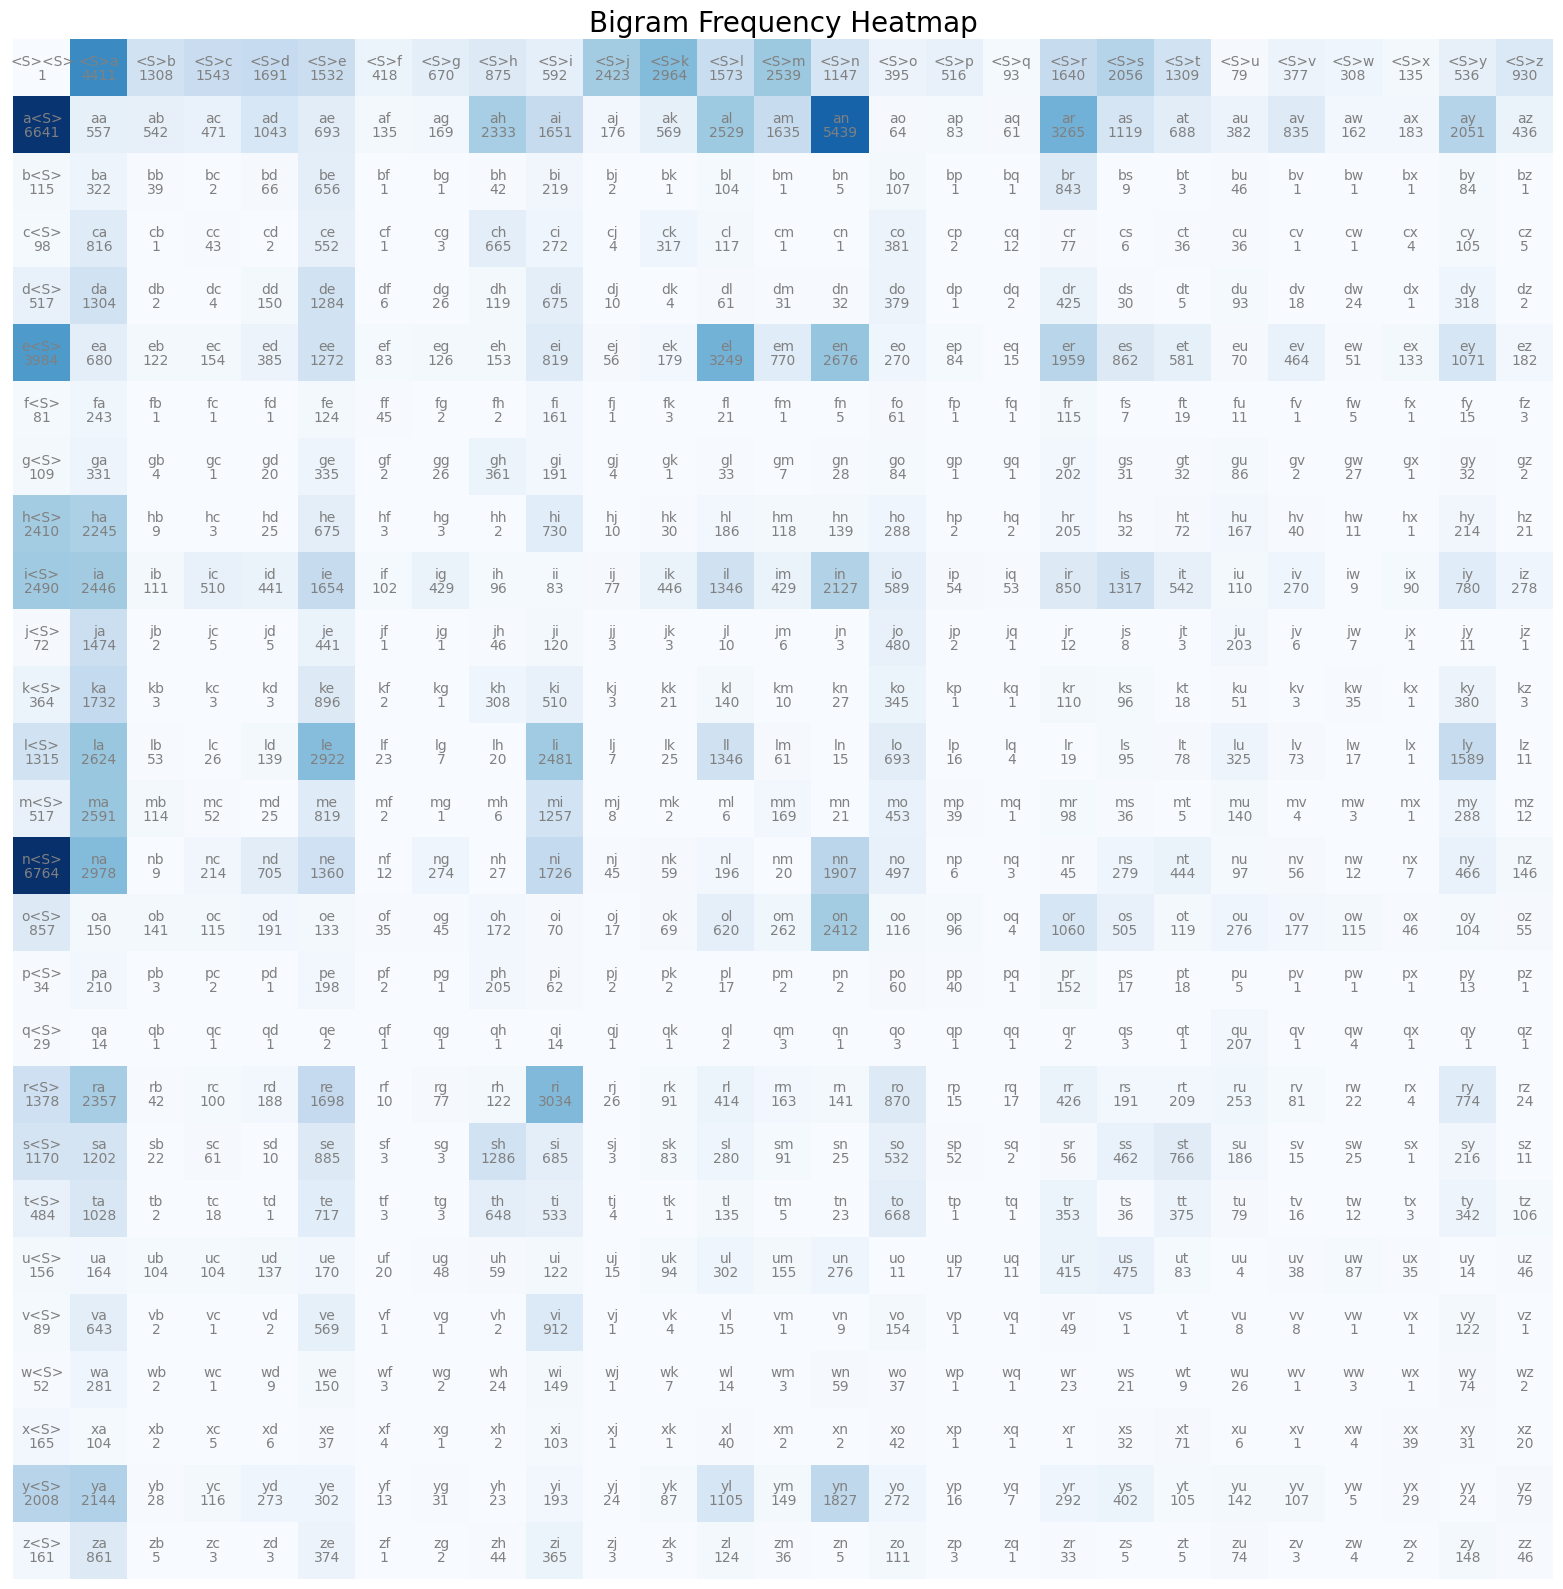

In [79]:
# plt.imshow(bigram_tensor, cmap=plt.cm.Blues)
# plt.show()


plt.figure(figsize=(16, 16))
plt.imshow(bigram_tensor, cmap=plt.cm.Blues)
for i in range(bigram_tensor.shape[0]):
    for j in range(bigram_tensor.shape[1]):
        ch_str: str = num_to_text.get(i, "?") + num_to_text.get(j, "?")
        # Add text for the chaaracters
        plt.text(
            j,
            i,
            ch_str,
            horizontalalignment="center",
            verticalalignment="bottom",
            color="gray",
        )
        # Add text for bigram counts
        plt.text(
            j,
            i,
            bigram_tensor[i, j].item(),
            horizontalalignment="center",
            verticalalignment="top",
            color="gray",
        )
plt.title("Bigram Frequency Heatmap", size=20)
plt.axis("off")
plt.tight_layout()
plt.show()

### Sample the names from the bigram count frequency

- Normalize the counts (convert to probabilities).
- Sample names based on the normalized counts using torch.multinoimial.
- To ensure reproducibility, use a fixed random seed (geneartor) before sampling.

In [80]:
# The same values will always be obtained
g = torch.Generator().manual_seed(20)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.3614, 0.1142, 0.5244])

In [81]:
torch.multinomial(p, num_samples=10, replacement=True, generator=g)

tensor([2, 0, 2, 1, 2, 0, 0, 2, 0, 2])

In [82]:
# Sample the names from the bigram count frequency
bigram_tensor[0, :]

tensor([   1, 4411, 1308, 1543, 1691, 1532,  418,  670,  875,  592, 2423, 2964,
        1573, 2539, 1147,  395,  516,   93, 1640, 2056, 1309,   79,  377,  308,
         135,  536,  930], dtype=torch.int32)

In [83]:
# Convert to probabilities
prob = bigram_tensor[0, :].float() / bigram_tensor[0, :].sum(0)
prob

tensor([3.1191e-05, 1.3758e-01, 4.0797e-02, 4.8127e-02, 5.2743e-02, 4.7784e-02,
        1.3038e-02, 2.0898e-02, 2.7292e-02, 1.8465e-02, 7.5575e-02, 9.2449e-02,
        4.9063e-02, 7.9193e-02, 3.5776e-02, 1.2320e-02, 1.6094e-02, 2.9007e-03,
        5.1152e-02, 6.4128e-02, 4.0828e-02, 2.4641e-03, 1.1759e-02, 9.6067e-03,
        4.2107e-03, 1.6718e-02, 2.9007e-02])

In [84]:
# Sample 3 words from the distribution
result: Tensor = torch.multinomial(prob, num_samples=3, replacement=True, generator=g)
result

tensor([19, 13, 26])

In [85]:
" ".join([num_to_text.get(idx.item()) for idx in result])

's m z'

In [86]:
g = torch.Generator().manual_seed(5)
result: list[str] = []

for _ in range(20):
    idx: int = 0  # Start from first word
    gen_names: list[str] = []

    while True:
        # Calculate the prob assuming it always starts from the first word (SPECIAL_TOKEN).
        # That why we set idx to 0 initially.
        prob: Tensor = bigram_tensor[idx].float()
        prob /= prob.sum()
        idx = torch.multinomial(
            prob, num_samples=1, replacement=True, generator=g
        ).item()
        gen_names.append(num_to_text.get(idx))

        if idx == 0:  # Reached the end of sentence
            break

    result.append(" ".join(gen_names))
    print(" ".join(gen_names))
# gen_names

k a r y u w <S>
k <S>
m a m u e s <S>
z <S>
g a m a n <S>
e r i h <S>
b r i l i <S>
d a f i <S>
a j a v e n <S>
m i a y o a <S>
m e <S>
a n <S>
h <S>
c i n <S>
a r y l e e s t t o s i c h <S>
a n n y l <S>
n o n <S>
k i o d e c o s h <S>
t <S>
a a y c t a <S>


### [Broadcasting](https://pytorch.org/docs/stable/notes/broadcasting.html)

- Each tensor has at least one dimension.
- When iterating over the dimension sizes, starting at the trailing dimension (i.e. right to left), the dimension sizes must either be equal, one of them is 1, or one of them does not exist.

```py
# 1.) Broadcastable

x = torch.tensor([[1, 2], [3, 4]])
y = torch.tensor([5, 6])

# ==== Initial Shapes ====:

# x has shape (2, 2)
# y has shape (2,)

# ==== Align the Shapes ====:
# To make two tensors broadcastable, PyTorch aligns their shapes starting from the trailing dimensions (rightmost). If necessary, it prepends dimensions of 
# size 1 to the smaller tensor to match the number of dimensions of the larger tensor.

# Shape of x: (2, 2)
# Shape of y: (2,)
# To align y with x, we can prepend a dimension of size 1 to y:
# Shape of y after alignment: (1, 2)

# ==== Broadcasting Rules ====:

# If the sizes of the current dimensions are equal, or one of them is 1, the tensors can be broadcast together along that dimension.
# Otherwise, the tensors are not broadcastable.
# Now, we compare the aligned shapes dimension by dimension:

# x has shape (2, 2)
# y has shape (1, 2)

# ====Compare the dimensions ====:

# For the first dimension: x has 2 and y has 1. Since one of the dimensions is 1, this is broadcastable.
# For the second dimension: Both x and y have 2. This is also broadcastable.
# Broadcasting Result:
# When performing an element-wise operation between x and y, PyTorch will broadcast y to match the shape of x:

# y is broadcast from shape (1, 2) to shape (2, 2) by replicating the row.


# 2.) NOT Broadcastable

a = torch.tensor([[1, 2, 3], [4, 5, 6]])
b = torch.tensor([7, 8])

# ==== Initial Shapes ====:

# a has shape (2, 3)
# b has shape (2,)

# ==== Align the Shapes ====:
# To align the shapes, we prepend dimensions of size 1 to the smaller tensor b:

# Shape of a: (2, 3)
# Shape of b: (1, 2)

# ==== Broadcasting Rules ====:

# If the sizes of the current dimensions are equal, or one of them is 1, the tensors can be broadcast together along that dimension.
# Otherwise, the tensors are not broadcastable.
# Now, we compare the aligned shapes dimension by dimension:

# a has shape (2, 3)
# b has shape (1, 2)

# ==== Compare the dimensions ====:

# For the first dimension: a has 2 and b has 1. Since one of the dimensions is 1, this is broadcastable.
# For the second dimension: a has 3 and b has 2. Neither dimension is 1, and the sizes are not equal. This makes the tensors not broadcastable.
# Therefore, the tensors a and b cannot be broadcasted together because their second dimensions do not align and cannot be matched by broadcasting rules. Here’s the summary:

# a has shape (2, 3)
# b has shape (2,) and aligns to (1, 2)
```



In [87]:
a = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([5, 6])
# b.shape

c = a @ b
c.shape
c

tensor([17, 39])

In [88]:
# Optimize the previous step
Prob: Tensor = bigram_tensor.float()
print(Prob.shape)

torch.Size([27, 27])


In [89]:
print(f"{Prob.sum(0, keepdim=True).shape=}")
print(f"{Prob.sum(0, keepdim=False).shape=}\n")

print(f"{Prob.sum(1, keepdim=True).shape=}")
print(f"{Prob.sum(1, keepdim=False).shape=}\n")

print(f"{Prob.sum(-1, keepdim=True).shape=}")
print(f"{Prob.sum(-1, keepdim=False).shape=}")

Prob.sum(0, keepdim=True).shape=torch.Size([1, 27])
Prob.sum(0, keepdim=False).shape=torch.Size([27])

Prob.sum(1, keepdim=True).shape=torch.Size([27, 1])
Prob.sum(1, keepdim=False).shape=torch.Size([27])

Prob.sum(-1, keepdim=True).shape=torch.Size([27, 1])
Prob.sum(-1, keepdim=False).shape=torch.Size([27])


### Note

```py
Prob.sum(1, keepdim=True).shape != Prob.sum(1, keepdim=False).shape != Prob.sum(0, keepdim=True).shape != Prob.sum(0, keepdim=False).shape
```

In [90]:
# This is what we want: Find the sum of all the numbers across the rows (1st index or -1/last index)
# It's very important to incldue keepdim=True so that the result has the same number of dimensions
print(f"{Prob.sum(-1, keepdim=True)=}")

Prob.sum(-1, keepdim=True)=tensor([[32061.],
        [33912.],
        [ 2674.],
        [ 3559.],
        [ 5523.],
        [20450.],
        [  932.],
        [ 1954.],
        [ 7643.],
        [17729.],
        [ 2927.],
        [ 5067.],
        [13985.],
        [ 6670.],
        [18354.],
        [ 7962.],
        [ 1053.],
        [  299.],
        [12727.],
        [ 8133.],
        [ 5597.],
        [ 3162.],
        [ 2600.],
        [  956.],
        [  724.],
        [ 9803.],
        [ 2425.]])


In [91]:
# Divide the 2 tensors using broadcasting
# Inplce divide to prevent creating a new tensor
Prob /= Prob.sum(-1, keepdim=True)  # Prob = Prob / Prob.sum(-1, keepdim=True)
Prob[:2]

tensor([[3.1191e-05, 1.3758e-01, 4.0797e-02, 4.8127e-02, 5.2743e-02, 4.7784e-02,
         1.3038e-02, 2.0898e-02, 2.7292e-02, 1.8465e-02, 7.5575e-02, 9.2449e-02,
         4.9063e-02, 7.9193e-02, 3.5776e-02, 1.2320e-02, 1.6094e-02, 2.9007e-03,
         5.1152e-02, 6.4128e-02, 4.0828e-02, 2.4641e-03, 1.1759e-02, 9.6067e-03,
         4.2107e-03, 1.6718e-02, 2.9007e-02],
        [1.9583e-01, 1.6425e-02, 1.5983e-02, 1.3889e-02, 3.0756e-02, 2.0435e-02,
         3.9809e-03, 4.9835e-03, 6.8796e-02, 4.8685e-02, 5.1899e-03, 1.6779e-02,
         7.4575e-02, 4.8213e-02, 1.6039e-01, 1.8872e-03, 2.4475e-03, 1.7988e-03,
         9.6279e-02, 3.2997e-02, 2.0288e-02, 1.1264e-02, 2.4623e-02, 4.7771e-03,
         5.3963e-03, 6.0480e-02, 1.2857e-02]])

In [92]:
g = torch.Generator().manual_seed(5)
result: list[str] = []

for _ in range(20):
    idx: int = 0  # Start from first word
    gen_names: list[str] = []

    while True:
        # Calculate the prob assuming it always starts from the first word (SPECIAL_TOKEN).
        # That why we set idx to 0 initially.
        prob: Tensor = Prob[idx].float()
        idx = torch.multinomial(
            prob, num_samples=1, replacement=True, generator=g
        ).item()
        gen_names.append(num_to_text.get(idx))

        if idx == 0:  # Reached the end of sentence
            break

    result.append(" ".join(gen_names))
    print(" ".join(gen_names))

k a r y u w <S>
k <S>
m a m u e s <S>
z <S>
g a m a n <S>
e r i h <S>
b r i l i <S>
d a f i <S>
a j a v e n <S>
m i a y o a <S>
m e <S>
a n <S>
h <S>
c i n <S>
a r y l e e s t t o s i c h <S>
a n n y l <S>
n o n <S>
k i o d e c o s h <S>
t <S>
a a y c t a <S>


### Evaluate The Quality Of The Model

- We're going to use the `Maximum Likelihood Estimation` (MLE) technique to evaluate the quality of our bigram model.
- `MLE` is a statistical method used to estimate the parameters of a probability distribution that best describes a given dataset.

### Estimate Model Quality

- The model predicts the probability of the next character given the previous character in a sequence.

#### Likelihood Calculation:

- Iterate through each sequence in the test dataset.
- For each character position (except the first), use the model to predict the probability of the current character given the previous character.
- Multiply these individual probabilities together to get the overall likelihood of the entire sequence according to the model.
  - i.e. log(a * b * c) = log(a) + log(b) + log(c)
- MLE Estimation:
  - The average of the log likelihoods (often used for numerical stability) across all sequences in the test dataset is considered the MLE estimate of the model's performance.
  - Convert to negative log likelihood since we want to minimize the objective rather than maximize it.

- Interpretation:
  - A lower negative log likelihood value (closer to 0) indicates the model is more likely to have generated the test dataset, suggesting better performance.
  - A higher negative log likelihood value suggests the model struggles to predict the character sequences in the test data.
  - ...
  - OR (a higher log likelihood value indicates better model performance).
  - OR (a lower log likelihood value suggests the model is less likely to have generated the test dataset, suggesting worse performance).

In [93]:
# Base probability: Any value > base prob means that the model has learned something.
base: float = 1 / len(characters)
print(f"Base probability: {base=:4f}\n")
neg_log_likelihood: float = 0.0
N: int = 0

for w in names[:3]:
    # for w in ["neidu"]: prob of producing the given text
    # Add special character(s) between words
    word: list[str] = [SPECIAL_TOKEN] + list(w) + [SPECIAL_TOKEN]
    for ch1, ch2 in zip(word, word[1:]):
        # Convert to index
        idx1, idx2 = text_to_num.get(ch1), text_to_num.get(ch2)
        p: float = Prob[idx1, idx2]
        logprop = torch.log(p)
        neg_log_likelihood += -logprop
        N += 1
        # Probability of the bigram occurance
        print(f"{ch1:3} {ch2:3}: {p.item()=:4f}")

avg_neg_log_likelihood: float = neg_log_likelihood / N

# This is the loss. The goal is to minimize it during training.
print((f"\n{neg_log_likelihood=:4f} \n{avg_neg_log_likelihood=:4f}"))

Base probability: base=0.037037

<S> e  : p.item()=0.047784
e   m  : p.item()=0.037653
m   m  : p.item()=0.025337
m   a  : p.item()=0.388456
a   <S>: p.item()=0.195830
<S> o  : p.item()=0.012320
o   l  : p.item()=0.077870
l   i  : p.item()=0.177404
i   v  : p.item()=0.015229
v   i  : p.item()=0.350769
i   a  : p.item()=0.137966
a   <S>: p.item()=0.195830
<S> a  : p.item()=0.137581
a   v  : p.item()=0.024623
v   a  : p.item()=0.247308
a   <S>: p.item()=0.195830

neg_log_likelihood=38.809193 
avg_neg_log_likelihood=2.425575


## Putting It Together

In [94]:
class Makemore:
    """A class for creating and working with a bigram language model."""

    def __init__(
        self, file_path: str, special_token: str = ".", seed: int = 42
    ) -> None:
        self.file_path = file_path
        self.special_token = special_token
        self.seed = seed

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}(file_path={self.file_path}, "
            f"special_token={self.special_token}, seed={self.seed})"
        )

    def load_data(self) -> list[str]:
        """Load text data from a file and return as a list of strings."""

        with open(self.file_path, "r") as f:
            # Read all the lines as a list
            data: list[str] = f.read().splitlines()

        return data

    def text_to_num(self) -> dict[str, int]:
        """Create a dictionary mapping characters to integers."""
        data: list[str] = self.load_data()

        # Number of unique characters
        charaters: list[str] = sorted(set([x for name in data for x in name]))
        charaters.insert(0, self.special_token)
        text_to_num: dict[str, int] = {text: idx for idx, text in enumerate(charaters)}

        return text_to_num

    def num_to_text(self) -> dict[str, int]:
        """Create a dictionary mapping integers to characters."""

        num_to_text: dict[int, str] = {
            idx: text for text, idx in self.text_to_num().items()
        }

        return num_to_text

    def create_bigram_tensor(self) -> Tensor:
        """
        Creates a bigram tensor from a list of strings.

        Params:
            None

        Returns:
            torch.Tensor: A 2D tensor representing the bigram counts of the characters in the data.
        """
        data: list[str] = self.load_data()
        text_to_num: dict[str, int] = self.text_to_num()
        num_chars: int = len(text_to_num)

        # Use int since it'll be storing counts.
        # torch.ones instead of zeros for model smoothening
        bigram_tensor: Tensor = torch.ones(
            size=(num_chars, num_chars), dtype=torch.int32
        )

        # Read 2 words at a time
        for w in data:
            # Add special character(s) between words
            word: list[str] = [self.special_token] + list(w) + [self.special_token]
            for ch1, ch2 in zip(word, word[1:]):
                # Convert to index
                idx1, idx2 = text_to_num.get(ch1), text_to_num.get(ch2)
                # Increment count
                bigram_tensor[idx1, idx2] += 1

        return bigram_tensor

    def generate_names(self, num_names: int, print_result: bool = False) -> list[str]:
        """
        Generates a list of randomly generated names using a pre-trained bigram model.

        Params:
            num_names (int): The number of names to generate.
            print_result (bool, optional): If True, prints the generated names. Defaults to False.

        Returns:
            list[str]: A list of generated names.
        """
        g = torch.Generator().manual_seed(self.seed)
        bigram_tensor: Tensor = self.create_bigram_tensor()
        # Convert numbers to text
        num_to_text: dict[int, str] = self.num_to_text()
        result: list[str] = []

        Prob: Tensor = bigram_tensor.float()
        # Divide the 2 tensors using broadcasting
        # Inplce divide to prevent creating a new tensor
        Prob /= Prob.sum(-1, keepdim=True)

        for _ in range(num_names):
            idx: int = 0  # Start from first word
            gen_names: list[str] = []

            while True:
                # Calculate the prob assuming it always starts from the first word (SPECIAL_TOKEN).
                # That why we set idx to 0 initially.
                prob: Tensor = Prob[idx].float()
                idx = torch.multinomial(
                    prob, num_samples=1, replacement=True, generator=g
                ).item()
                gen_names.append(num_to_text.get(idx))

                if idx == 0:  # Reached the end of sentence
                    break

            result.append("".join(gen_names))

            if print_result:
                print("".join(gen_names))

        return result

In [95]:
fp: str = "../../../data/names.txt"

bigram_model: Makemore = Makemore(file_path=fp, seed=1)
bigram_model.generate_names(num_names=20)

['h.',
 'deres.',
 'ena.',
 'coge.',
 'wicayayaranann.',
 'linil.',
 'rinilelivenayen.',
 'tarilezz.',
 'a.',
 'vvicruverleimme.',
 'karo.',
 'sisma.',
 'ellalevenylan.',
 'mi.',
 'konabree.',
 'mion.',
 'ch.',
 'almnveravithanahm.',
 'viynynade.',
 'kakylylanondala.']

## Create An N-Gram Model

In [96]:
n: int = 3  # number of characters in each n-gram
special_token: str = (
    "<S>"  # special character to add at the beginning and end of the word
)
n_chars: int = len(text_to_num)
ngram_tensor: Tensor = torch.ones(size=(n_chars,) * n, dtype=torch.int32)
ngram_tensor.shape

torch.Size([27, 27, 27])

In [97]:
for w in names[:1]:
    # Add special character(s) at the beginning and end of the word
    word: list[str] = [special_token] * (n - 1) + list(w) + [special_token]
    print(f"{word=}")
    for i in range(len(word) - n + 1):
        print(f"{i=}")
        indices = [text_to_num[word[j]] for j in range(i, i + n)]
        print(f"{indices=}")
        # ngram_tensor[tuple(indices)] += 1

word=['<S>', '<S>', 'e', 'm', 'm', 'a', '<S>']
i=0
indices=[0, 0, 5]
i=1
indices=[0, 5, 13]
i=2
indices=[5, 13, 13]
i=3
indices=[13, 13, 1]
i=4
indices=[13, 1, 0]


In [98]:
for w in names:
    # Add special character(s) at the beginning and end of the word
    word: list[str] = [special_token] * (n - 1) + list(w) + [special_token]  # * (n - 1)
    for i in range(len(word) - n + 1):
        indices = [text_to_num[word[j]] for j in range(i, i + n)]
        ngram_tensor[tuple(indices)] += 1

In [99]:
print(tuple(range(-n + 1, 0)))
Prob: Tensor = ngram_tensor.float()
print(f"{Prob.shape=}")
p_sum = Prob.sum(tuple(range(-n + 1, 0)), keepdim=True)
print(f"{p_sum.shape=}")
p_sum

(-2, -1)
Prob.shape=torch.Size([27, 27, 27])
p_sum.shape=torch.Size([27, 1, 1])


tensor([[[64797.]],

        [[27974.]],

        [[ 3262.]],

        [[ 4164.]],

        [[ 5709.]],

        [[17169.]],

        [[ 1554.]],

        [[ 2548.]],

        [[ 5936.]],

        [[15942.]],

        [[ 3558.]],

        [[ 5406.]],

        [[13373.]],

        [[ 6856.]],

        [[12293.]],

        [[ 7808.]],

        [[ 1722.]],

        [[  973.]],

        [[12052.]],

        [[ 7666.]],

        [[ 5816.]],

        [[ 3709.]],

        [[ 3214.]],

        [[ 1607.]],

        [[ 1262.]],

        [[ 8498.]],

        [[ 2967.]]])

In [100]:
Prob: Tensor = ngram_tensor.float()
print(f"{Prob.shape=}")
p_sum_2 = Prob.sum((-1, -2), keepdim=True)
print(f"{p_sum_2.shape=}")
p_sum_2

Prob.shape=torch.Size([27, 27, 27])
p_sum_2.shape=torch.Size([27, 1, 1])


tensor([[[64797.]],

        [[27974.]],

        [[ 3262.]],

        [[ 4164.]],

        [[ 5709.]],

        [[17169.]],

        [[ 1554.]],

        [[ 2548.]],

        [[ 5936.]],

        [[15942.]],

        [[ 3558.]],

        [[ 5406.]],

        [[13373.]],

        [[ 6856.]],

        [[12293.]],

        [[ 7808.]],

        [[ 1722.]],

        [[  973.]],

        [[12052.]],

        [[ 7666.]],

        [[ 5816.]],

        [[ 3709.]],

        [[ 3214.]],

        [[ 1607.]],

        [[ 1262.]],

        [[ 8498.]],

        [[ 2967.]]])

In [101]:
p_sum.equal(p_sum_2)

True

In [102]:
tuple(sorted(range(-n + 1, 0, 1), reverse=True))

(-1, -2)

In [103]:
g = torch.Generator().manual_seed(5)

# Convert counts to probabilities
Prob: Tensor = ngram_tensor.float()
idxs: tuple[int, ...] = tuple(sorted(range(-n + 1, 0, 1), reverse=True))
Prob /= Prob.sum(idxs, keepdim=True)

for _ in range(10):
    output: list[str] = []
    # Start from the special tokens
    indices: tuple[int, ...] = tuple([0] * (n - 1))

    while True:
        p: Tensor = Prob[indices].float()
        next_idx: int = torch.multinomial(
            p, num_samples=1, replacement=True, generator=g
        ).item()
        # Add the next character to the output
        output.append(num_to_text[next_idx])

        if next_idx == 0:  # Reached the end of sentence
            break

        # Update the indices. i.e. given the prev character, predict the next one
        indices = indices[1:] + (next_idx,)

    # Print the generated text
    print("".join(output))

karyiwzipton<S>
es<S>
zacamarierihanna<S>
hadyfp<S>
alynen<S>
mi<S>
joa<S>
medan<S>
hucin<S>
aryseestordickeyanylanoa<S>


In [104]:
class Makemore:
    """A class for creating and working with a bigram language model."""

    def __init__(
        self, file_path: str, n: int, special_token: str = ".", seed: int = 42
    ) -> None:
        self.file_path = file_path
        self.n = n
        self.special_token = special_token
        self.seed = seed

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}(file_path={self.file_path}, "
            f"special_token={self.special_token}, seed={self.seed})"
        )

    def load_data(self) -> list[str]:
        """Load text data from a file and return as a list of strings."""

        with open(self.file_path, "r") as f:
            # Read all the lines as a list
            data: list[str] = f.read().splitlines()

        return data

    def text_to_num(self) -> dict[str, int]:
        """Create a dictionary mapping characters to integers."""
        data: list[str] = self.load_data()

        # Number of unique characters
        charaters: list[str] = sorted(set([x for name in data for x in name]))
        charaters.insert(0, self.special_token)
        text_to_num: dict[str, int] = {text: idx for idx, text in enumerate(charaters)}

        return text_to_num

    def num_to_text(self) -> dict[str, int]:
        """Create a dictionary mapping integers to characters."""

        num_to_text: dict[int, str] = {
            idx: text for text, idx in self.text_to_num().items()
        }

        return num_to_text

    def create_ngram_tensor(self) -> Tensor:
        """
        Creates an ngram tensor from a list of strings.

        Params:
            None

        Returns:
            torch.Tensor: An N-D tensor representing the ngram counts of the characters in the data.
        """
        data: list[str] = self.load_data()
        text_to_num: dict[str, int] = self.text_to_num()
        num_chars: int = len(text_to_num)

        # Use int since it'll be storing counts.
        # torch.ones instead of zeros for model smoothening
        ngram_tensor: Tensor = torch.ones(
            size=((num_chars,) * self.n), dtype=torch.int32
        )

        # Read N words at a time
        for w in data:
            # Add special character(s) between words
            word: list[str] = (
                [self.special_token] * (self.n - 1) + list(w) + [self.special_token]
            )

            for i in range(len(word) - self.n + 1):
                # Get indices of the characters in the word.
                # This will be used to create the n-gram tensor.
                idxs: list[int] = [
                    text_to_num.get(word[j]) for j in range(i, i + self.n)
                ]
                # Increment count
                ngram_tensor[tuple(idxs)] += 1

        return ngram_tensor

    def generate_names(self, num_names: int, print_result: bool = False) -> list[str]:
        """
        Generates a list of randomly generated names using a pre-trained bigram model.

        Params:
            num_names (int): The number of names to generate.
            print_result (bool, optional): If True, prints the generated names. Defaults to False.

        Returns:
            list[str]: A list of generated names.
        """
        g = torch.Generator().manual_seed(self.seed)
        ngram_tensor: Tensor = self.create_ngram_tensor()
        # Convert numbers to text
        num_to_text: dict[int, str] = self.num_to_text()
        result: list[str] = []

        Prob: Tensor = ngram_tensor.float()
        ngram_size: tuple[int, ...] = tuple(sorted(range(-self.n + 1, 0), reverse=True))
        Prob /= Prob.sum(dim=ngram_size, keepdim=True)

        for _ in range(num_names):
            gen_names: list[str] = []
            # Start from first (n - 1) words
            idxs: list[int] = [0] * (self.n - 1)

            while True:
                # Calculate the prob assuming it always starts from the first word (SPECIAL_TOKEN).
                # That why we set idx to 0 initially.
                prob: Tensor = Prob[tuple(idxs)].float()
                next_idx: int = torch.multinomial(
                    prob, num_samples=1, replacement=True, generator=g
                ).item()
                gen_names.append(num_to_text.get(next_idx))

                if next_idx == 0:  # Reached the end of sentence
                    break

                # Update the indices. i.e. given the prev character, predict the next one
                idxs = idxs[1:] + [next_idx]

            result.append("".join(gen_names))

            if print_result:
                print("".join(gen_names))

        return result

    def calculate_loss(self) -> float:
        """Calculate the loss of the model."""

        data: list[str] = self.load_data()
        text_to_num: dict[str, int] = self.text_to_num()
        # Base probability: Any value > base prob means that the model has learned something.
        base: float = 1 / len(text_to_num)
        print(f"Base probability: {base=:4f}\n")

        Prob: Tensor = self.create_ngram_tensor().float()
        ngram_size: tuple[int, ...] = tuple(sorted(range(-self.n + 1, 0), reverse=True))
        Prob /= Prob.sum(dim=ngram_size, keepdim=True)
        neg_log_likelihood: float = 0.0
        N: int = 0

        for w in data:
            # Add special character(s) between words
            word: list[str] = (
                [self.special_token] * (self.n - 1) + list(w) + [self.special_token]
            )

            for i in range(len(word) - self.n + 1):
                # Get indices of the characters in the word.
                # This will be used to create the n-gram tensor.
                idxs: list[int] = [
                    text_to_num.get(word[j]) for j in range(i, i + self.n)
                ]
                p: float = Prob[tuple(idxs)]
                logprop = torch.log(p)
                neg_log_likelihood += -logprop
                N += 1

        avg_neg_log_likelihood: float = neg_log_likelihood / N

        # This is the loss. The goal is to minimize it during training.
        print(f"\n{avg_neg_log_likelihood=:4f}")

In [105]:
makemore = Makemore(file_path=fp, n=2)
generated_texts = makemore.generate_names(num_names=10, print_result=False)
generated_texts

['ya.',
 'syahavilin.',
 'dleekahmangonya.',
 'tryahe.',
 'chen.',
 'ena.',
 'da.',
 'amiiae.',
 'a.',
 'keles.']

In [106]:
makemore.calculate_loss()

Base probability: base=0.037037


avg_neg_log_likelihood=2.454376


In [107]:
makemore = Makemore(file_path=fp, n=3)
generated_texts = makemore.generate_names(num_names=10, print_result=False)
generated_texts

['ye.',
 'syahle.',
 'amen.',
 'leekkim.',
 'mannya.',
 'tryahd.',
 'chen.',
 'emaellyn.',
 'jiah.',
 'abieles.']

In [108]:
makemore.calculate_loss()

Base probability: base=0.037037


avg_neg_log_likelihood=4.530460


In [109]:
makemore = Makemore(file_path=fp, n=4)
generated_texts = makemore.generate_names(num_names=10, print_result=False)
generated_texts

['yeosyah.',
 'malin.',
 'dlxgktsmzmgwnyb.',
 'tryvwdxchwnden.',
 'ell.',
 'amiiaeqybkejmszqsqgtoyzjovtkimpupooznnyzijfosjvslrumxton.',
 'clpgcyanahivzion.',
 'arten.',
 'kirsumaim.',
 'eiliony.']

In [110]:
makemore.calculate_loss()

Base probability: base=0.037037


avg_neg_log_likelihood=6.798744


### Comment

- It seems that the model performs poorly when n > 3.

## Bigram Charater-Level Model Using Neural Networks

- Using gradient based optimisation to tune the parameters of the model so that the model assigns a high probability to the prediction of the next character.

In [111]:
special_token: str = "."
# Number of unique characters
characters: list[str] = sorted(set([x for name in names for x in name]))
characters.insert(0, special_token)

print(f"Number of unique characters: {len(characters)}")

# Convert text to numbers.
text_to_num: dict[str, int] = {text: idx for idx, text in enumerate(characters)}
# Convert numbers to text
num_to_text: dict[int, str] = {idx: text for text, idx in text_to_num.items()}
# console.print(text_to_num, num_to_text)

Number of unique characters: 27


In [112]:
n: int = 2
X, y = [], []

# Read N words at a time
for w in names[:1]:
    # Add special character(s) between words
    word: list[str] = [special_token] * (n - 1) + list(w) + [special_token]

    for i in range(len(word) - n + 1):
        # Get indices of the characters in the word.
        # This will be used to create the n-gram tensor.
        idxs: list[int] = [text_to_num.get(word[j]) for j in range(i, i + n)]
        chars: list[str] = [word[j] for j in range(i, i + n)]
        print(f"{chars=}")
        X.append(idxs[0])
        y.append(idxs[1])

X_tensor: Tensor = torch.tensor(X)
y_tensor: Tensor = torch.tensor(y)

chars=['.', 'e']
chars=['e', 'm']
chars=['m', 'm']
chars=['m', 'a']
chars=['a', '.']


In [113]:
X_tensor, y_tensor

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

### Encode The Input Data.

- This is necessary because the model is a neural network and it needs to be able to process the data.
- Encoding input data into a neural network is necessary to ensure that the data is in a format that facilitates effective learning.
- Large integer values can cause training instability, fail to capture relationships between inputs, and hinder the network's ability to learn non-linear patterns.
- Using methods like `one-hot encoding` or `embeddings` ensures that the data is normalized, semantically meaningful, and suitable for the network's architecture and learning process.

In [114]:
import torch.nn.functional as F


# It's better to use floats instead of ints for neural nets
X_enc: Tensor = F.one_hot(X_tensor, num_classes=num_chars).float()
print(f"{X_enc.shape = }")
X_enc

X_enc.shape = torch.Size([5, 27])


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

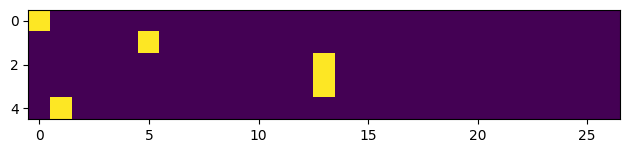

In [115]:
plt.imshow(X_enc)
plt.tight_layout()
plt.show()

In [116]:
# Matric Multiplication
torch.manual_seed(0)
# Weight
W: Tensor = torch.randn((n_chars, n_chars))

# Log-counts
logits: Tensor = X_enc @ W
print(f"{logits.shape = }")
logits

logits.shape = torch.Size([5, 27])


tensor([[-1.1258, -1.1524, -0.2506, -0.4339,  0.8487,  0.6920, -0.3160, -2.1152,
          0.3223, -1.2633,  0.3500,  0.3081,  0.1198,  1.2377,  1.1168, -0.2473,
         -1.3527, -1.6959,  0.5667,  0.7935,  0.5988, -1.5551, -0.3414,  1.8530,
          0.7502, -0.5855, -0.1734],
        [-1.0631, -0.0773,  0.1164, -0.5940, -1.2439, -0.1021, -1.0335, -0.3126,
          0.2458, -0.2596,  0.1183,  0.2440,  1.1646,  0.2886,  0.3866, -0.2011,
         -0.1179,  0.1922, -0.7722, -1.9003,  0.1307, -0.7043,  0.3147,  0.1574,
          0.3854,  0.9671, -0.9911],
        [-1.1038,  0.5411,  1.5390,  1.0860,  1.2464,  0.1151,  1.6193,  0.4637,
          1.3007,  0.8732,  0.0651,  0.7732, -0.9701, -0.8877, -0.3183, -0.3344,
          0.4543,  0.4990,  0.8780,  0.3894,  1.4625,  0.4795, -0.5334, -0.0347,
          0.6573, -0.3112, -0.5620],
        [-1.1038,  0.5411,  1.5390,  1.0860,  1.2464,  0.1151,  1.6193,  0.4637,
          1.3007,  0.8732,  0.0651,  0.7732, -0.9701, -0.8877, -0.3183, -0.3344

In [117]:
# Convert the output (log-counts) to counts similar to the bigram_tensor.
counts: Tensor = torch.exp(logits)
counts

tensor([[0.3244, 0.3159, 0.7784, 0.6480, 2.3366, 1.9977, 0.7291, 0.1206, 1.3803,
         0.2827, 1.4190, 1.3609, 1.1273, 3.4475, 3.0550, 0.7809, 0.2586, 0.1834,
         1.7624, 2.2111, 1.8200, 0.2112, 0.7108, 6.3790, 2.1174, 0.5568, 0.8408],
        [0.3454, 0.9256, 1.1234, 0.5521, 0.2882, 0.9029, 0.3557, 0.7315, 1.2786,
         0.7713, 1.1256, 1.2763, 3.2046, 1.3345, 1.4720, 0.8179, 0.8888, 1.2119,
         0.4620, 0.1495, 1.1396, 0.4945, 1.3699, 1.1705, 1.4701, 2.6304, 0.3712],
        [0.3316, 1.7180, 4.6597, 2.9625, 3.4778, 1.1220, 5.0496, 1.5899, 3.6720,
         2.3946, 1.0673, 2.1668, 0.3790, 0.4116, 0.7274, 0.7158, 1.5750, 1.6470,
         2.4061, 1.4762, 4.3168, 1.6153, 0.5866, 0.9659, 1.9296, 0.7325, 0.5701],
        [0.3316, 1.7180, 4.6597, 2.9625, 3.4778, 1.1220, 5.0496, 1.5899, 3.6720,
         2.3946, 1.0673, 2.1668, 0.3790, 0.4116, 0.7274, 0.7158, 1.5750, 1.6470,
         2.4061, 1.4762, 4.3168, 1.6153, 0.5866, 0.9659, 1.9296, 0.7325, 0.5701],
        [1.2014, 4.0123,

In [118]:
prob: Tensor = counts / counts.sum(-1, keepdim=True)
print(f"{prob.shape=}")
prob

prob.shape=torch.Size([5, 27])


tensor([[0.0087, 0.0085, 0.0209, 0.0174, 0.0629, 0.0538, 0.0196, 0.0032, 0.0371,
         0.0076, 0.0382, 0.0366, 0.0303, 0.0928, 0.0822, 0.0210, 0.0070, 0.0049,
         0.0474, 0.0595, 0.0490, 0.0057, 0.0191, 0.1717, 0.0570, 0.0150, 0.0226],
        [0.0124, 0.0332, 0.0403, 0.0198, 0.0103, 0.0324, 0.0128, 0.0263, 0.0459,
         0.0277, 0.0404, 0.0458, 0.1150, 0.0479, 0.0528, 0.0294, 0.0319, 0.0435,
         0.0166, 0.0054, 0.0409, 0.0177, 0.0492, 0.0420, 0.0528, 0.0944, 0.0133],
        [0.0066, 0.0342, 0.0927, 0.0589, 0.0692, 0.0223, 0.1005, 0.0316, 0.0731,
         0.0476, 0.0212, 0.0431, 0.0075, 0.0082, 0.0145, 0.0142, 0.0313, 0.0328,
         0.0479, 0.0294, 0.0859, 0.0321, 0.0117, 0.0192, 0.0384, 0.0146, 0.0113],
        [0.0066, 0.0342, 0.0927, 0.0589, 0.0692, 0.0223, 0.1005, 0.0316, 0.0731,
         0.0476, 0.0212, 0.0431, 0.0075, 0.0082, 0.0145, 0.0142, 0.0313, 0.0328,
         0.0479, 0.0294, 0.0859, 0.0321, 0.0117, 0.0192, 0.0384, 0.0146, 0.0113],
        [0.0249, 0.0833,

In [119]:
# Every row must sum to 1
print(f"{prob[0].sum()=} , {prob[4].sum()=}")

prob[0].sum()=tensor(1.) , prob[4].sum()=tensor(1.0000)


In [120]:
X_tensor, y_tensor

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

In [121]:
# Grab the index of X and the value of y
print(f"Prob of 0 predicting 15: {prob[0, 5]:.4f}")
print(f"Prob of 5 predicting 13: {prob[1, 13]:.4f}")
print(f"Prob of 13 predicting 13: {prob[2, 13]:.4f}")
print(f"Prob of 13 predicting 1: {prob[3, 1]:.4f}")
print(f"Prob of 1 predicting 10: {prob[4, 0]:.4f}")

Prob of 0 predicting 15: 0.0538
Prob of 5 predicting 13: 0.0479
Prob of 13 predicting 13: 0.0082
Prob of 13 predicting 1: 0.0342
Prob of 1 predicting 10: 0.0249


In [122]:
# A better approach( Vectorized )
prob[torch.arange(len(prob)), y_tensor]

tensor([0.0538, 0.0479, 0.0082, 0.0342, 0.0249])

In [123]:
# Loss: average negative log likelihood. Lower is better.
loss: Tensor = -1 * torch.log(prob[torch.arange(len(prob)), y_tensor]).mean()
loss

tensor(3.5669)

### Putting It Together

In [124]:
# Initialize 27 neuron weights with random values. Each neurn receives 27 inputs
g = torch.Generator().manual_seed(0)
W: Tensor = torch.rand(
    27,  # number of inputs
    27,  # number of neurons
    generator=g,
    requires_grad=True,
)

In [125]:
n: int = 2
X, y = [], []

# Read N words at a time
for w in names:
    # Add special character(s) between words
    word: list[str] = [special_token] * (n - 1) + list(w) + [special_token]

    for i in range(len(word) - n + 1):
        # Get indices of the characters in the word.
        # This will be used to create the n-gram tensor.
        idxs: list[int] = [text_to_num.get(word[j]) for j in range(i, i + n)]
        chars: list[str] = [word[j] for j in range(i, i + n)]
        # print(f"{chars=}")
        X.append(idxs[0])
        y.append(idxs[1])

X_tensor: Tensor = torch.tensor(X)
y_tensor: Tensor = torch.tensor(y)

In [126]:
X_tensor.shape, y_tensor.shape

(torch.Size([228152]), torch.Size([228152]))

In [127]:
# ====== Forward Pass ======
# Encode the input
X_enc: Tensor = F.one_hot(X_tensor, num_classes=num_chars).float()
print(f"{X_enc.shape=}")
logits: Tensor = X_enc @ W
# Convert to the counts/frequency of occurrence
counts: Tensor = logits.exp()
# Probs for predicting the next charater. (Softmax)
prob: Tensor = counts / counts.sum(dim=1, keepdim=True)
# Loss: Average negative log likelihood (for classification)
loss: Tensor = -torch.log(prob[torch.arange(len(prob)), y]).mean()
loss

X_enc.shape=torch.Size([228152, 27])


tensor(3.3241, grad_fn=<NegBackward0>)

In [128]:
# ====== Backward Pass ======
# Reset the gradients
W.grad = None

# Calculate the gradients
loss.backward()

In [129]:
# It shows the impacts of the weights on the loss function.
W.grad

tensor([[ 5.0239e-03, -1.2735e-02, -2.3871e-03, -3.2684e-03, -3.2479e-03,
         -9.4414e-04,  3.1653e-03,  4.5639e-03,  9.9311e-04,  3.1657e-03,
         -6.2802e-03, -8.4162e-03, -3.7625e-03, -7.5029e-03, -9.1947e-04,
          3.4101e-03,  3.8876e-03,  6.4038e-03, -3.5908e-03, -4.9511e-03,
          3.1397e-04,  7.2962e-03,  2.9016e-03,  5.9854e-03,  4.0650e-03,
          2.9718e-03,  3.8584e-03],
        [-2.5651e-02,  1.5709e-03,  2.4665e-03,  2.4582e-03,  3.8901e-03,
          9.3759e-04,  3.7743e-03,  3.1354e-03, -6.7838e-03, -3.1314e-03,
          7.6716e-03,  4.3733e-03, -4.0842e-03, -1.5251e-03, -1.9586e-02,
          5.6990e-03,  3.0830e-03,  3.5627e-03, -1.0063e-02,  2.6267e-03,
          4.3497e-03,  2.7286e-03,  1.7369e-03,  6.8538e-03,  8.2281e-03,
         -2.2896e-03,  3.9676e-03],
        [ 6.6374e-05, -1.1054e-03,  2.7779e-04,  2.7034e-04,  1.3563e-06,
         -2.5582e-03,  5.0758e-04,  4.9497e-04,  1.2134e-04, -4.8468e-04,
          5.2829e-04,  3.8005e-04, -3.88

In [130]:
# Update the parameters. This should reduce the loss
# There's no need for a loop since it's a single layer network
learning_rate: float = 0.01
W.data += -learning_rate * W.grad

## Train The Model Using A Neural Net

- Using the previous approach (statistical approach which involves using the frequency of the names), we trained a model with a loss of ~ 2.45.
- The goal is to train a neural net with similar performance.
- The architecture of the neural net is shown below.
  - Input layer: Character (index) which has been onehot encoded to a 2-D tensor (N x 27)
  - The labels (0 to 26) are indexes of the 27 unique characters (special token + 26 letters).
  - It has a single layer with 27 neurons.
  - The output layer has 27 neurons with a softmax activation function.

In [131]:
n: int = 2
X, y = [], []

# Read N words at a time
for w in names:
    # Add special character(s) between words
    word: list[str] = [special_token] * (n - 1) + list(w) + [special_token]

    for i in range(len(word) - n + 1):
        # Get indices of the characters in the word.
        # This will be used to create the n-gram tensor.
        idxs: list[int] = [text_to_num.get(word[j]) for j in range(i, i + n)]
        chars: list[str] = [word[j] for j in range(i, i + n)]
        # print(f"{chars=}")
        X.append(idxs[0])
        y.append(idxs[1])

X_tensor: Tensor = torch.tensor(X)
y_tensor: Tensor = torch.tensor(y)

# Initialize 27 neuron weights with random values. Each neurn receives 27 inputs
g = torch.Generator().manual_seed(0)
W: Tensor = torch.rand(
    27,  # number of inputs
    27,  # number of neurons
    generator=g,
    requires_grad=True,
)

In [132]:
epochs: int = 300


for epoch in range(epochs):
    # ====== Forward Pass ======
    # Encode the input
    X_enc: Tensor = F.one_hot(X_tensor, num_classes=num_chars).float()
    logits: Tensor = X_enc @ W
    # Convert to the counts/frequency of occurrence
    counts: Tensor = logits.exp()
    # Probs for predicting the next charater. (Softmax)
    prob: Tensor = counts / counts.sum(dim=1, keepdim=True)
    # Loss: Average negative log likelihood (for classification)
    # Regularization
    weight_reg: Tensor = (W**2).mean() * 0.007
    loss: Tensor = -torch.log(prob[torch.arange(len(prob)), y]).mean() + weight_reg

    # ====== Backward Pass ======
    # Reset the gradients
    W.grad = None

    # Calculate the gradients
    loss.backward()

    # Update the parameters. This should reduce the loss
    # There's no need for a loop since it's a single layer network
    learning_rate: float = 75
    W.data += -learning_rate * W.grad

    print(f"Epoch: {epoch+1}/{epochs} | Loss: {loss.item():.4f}")
print("Done!")

Epoch: 1/300 | Loss: 3.3264
Epoch: 2/300 | Loss: 2.9642
Epoch: 3/300 | Loss: 2.8127
Epoch: 4/300 | Loss: 2.7291
Epoch: 5/300 | Loss: 2.6779
Epoch: 6/300 | Loss: 2.6439
Epoch: 7/300 | Loss: 2.6195
Epoch: 8/300 | Loss: 2.6010
Epoch: 9/300 | Loss: 2.5866
Epoch: 10/300 | Loss: 2.5749
Epoch: 11/300 | Loss: 2.5654
Epoch: 12/300 | Loss: 2.5573
Epoch: 13/300 | Loss: 2.5505
Epoch: 14/300 | Loss: 2.5446
Epoch: 15/300 | Loss: 2.5395
Epoch: 16/300 | Loss: 2.5350
Epoch: 17/300 | Loss: 2.5310
Epoch: 18/300 | Loss: 2.5275
Epoch: 19/300 | Loss: 2.5243
Epoch: 20/300 | Loss: 2.5214
Epoch: 21/300 | Loss: 2.5188
Epoch: 22/300 | Loss: 2.5164
Epoch: 23/300 | Loss: 2.5143
Epoch: 24/300 | Loss: 2.5123
Epoch: 25/300 | Loss: 2.5104
Epoch: 26/300 | Loss: 2.5087
Epoch: 27/300 | Loss: 2.5072
Epoch: 28/300 | Loss: 2.5057
Epoch: 29/300 | Loss: 2.5044
Epoch: 30/300 | Loss: 2.5031
Epoch: 31/300 | Loss: 2.5020
Epoch: 32/300 | Loss: 2.5009
Epoch: 33/300 | Loss: 2.4998
Epoch: 34/300 | Loss: 2.4989
Epoch: 35/300 | Loss: 2

In [133]:
g = torch.Generator().manual_seed(8)

for _ in range(10):
    gen_names: list[str] = []
    # Start from first (n - 1) words
    idx: int = 0

    while True:
        X_enc: Tensor = F.one_hot(torch.tensor([idx]), num_classes=num_chars).float()
        logits: Tensor = X_enc @ W
        counts: Tensor = torch.exp(logits)
        # Calculate the prob assuming it always starts from the first word (SPECIAL_TOKEN).
        # That why we set idx to 0 initially.
        prob: Tensor = counts / counts.sum(-1, keepdim=True)
        next_idx: int = torch.multinomial(
            prob, num_samples=1, replacement=True, generator=g
        ).item()
        gen_names.append(num_to_text.get(next_idx))

        if next_idx == 0:  # Reached the end of sentence
            break

        # Update the indices. i.e. given the prev character, predict the next one
        idx = next_idx

    result.append("".join(gen_names))

    print("".join(gen_names))

al.
arlyavano.
ya.
rn.
wiaeri.
livyrie.
rn.
rille.
kaellwinda.
ai.
